# Code for reproducing the results in:

## Turning Ecology Against Pesticide Resistance: Exploiting Competition in Pest Populations Through Pesticide Use 

by Guariento et al.

In [1]:
import pandas as pd
import numpy as np
import scipy.integrate
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --------------------------- Model -----------------------------------------------------

def lotka_volterra(t, uVec, paramDic):
    s, r, v, c = uVec
    dudtVec = np.zeros_like(uVec) 
    dudtVec[0] = paramDic['rS']*(1-paramDic['dD']*c)*(1 - (s + paramDic['cRS'] * r)/paramDic['k']) * s 
    dudtVec[1] = paramDic['rR']*(1 - (r + paramDic['cSR'] * s)/paramDic['k'])*r 
    dudtVec[2] = paramDic['theta']*(dudtVec[0] + dudtVec[1])
    dudtVec[3] = 0
    return (dudtVec)

In [3]:
# --------------------------- Simulation -----------------------------------------------------

def Simulate_pestice_max(initialStateVec,paramDic,modelFun,t_end=None,t_span=None,t_eval=None,nTimePts=100,**kwargs):
    t_span = t_span if t_span is not None else (0, t_end)
    t_eval = t_eval if t_eval is not None else np.linspace(t_span[0],t_span[1],nTimePts)
    solObj = scipy.integrate.solve_ivp(lambda t, uVec: modelFun(t,uVec,paramDic), y0=initialStateVec,
                                       t_span=t_span,t_eval=t_eval,**kwargs)
    return pd.DataFrame({"Time": solObj.t, "S": solObj.y[0, :], "R": solObj.y[1, :],
                              "V":solObj.y[2,:], "D": solObj.y[3, :]})

def Simulate_non_int_fixed_target(initialStateVec,paramDic,modelFun,
                               rpuThreshold=0.5,intervalLength=3,refSize=None,t_end=None,t_span=None,t_eval=None,nTimePts=100,**kwargs):
    t_span = t_span if t_span is not None else (0, t_end)
    t_eval = t_eval if t_eval is not None else np.linspace(0,t_end,nTimePts)
    resultsDFList = []
    currInterval = [t_span[0],t_span[0]+intervalLength]
    refSize = initialStateVec[2] if refSize is None else refSize
    dose = initialStateVec[-1] 
    currCycleId = 0
    while currInterval[1] <= t_end: 
        # Simulate
        resultsDf = Simulate_pestice_max(initialStateVec,modelFun=modelFun,
                                         paramDic=paramDic,
                                         t_span=(currInterval[0], currInterval[1]),
                                         t_eval=np.linspace(currInterval[0], currInterval[1],1200)) #tEnd
        resultsDf['CycleId'] = currCycleId
        resultsDFList.append(resultsDf)

        # Update dose
        if resultsDf.V.iat[-1] > refSize:
            currCycleId += (dose==0)
            dose = paramDic['DMax']
        elif resultsDf.V.iat[-1] < (1-rpuThreshold)*refSize:
            dose = 0
        else:
            dose = (dose > 0)*paramDic['DMax']
        initialStateVec = [resultsDf.S.iat[-1], resultsDf.R.iat[-1], resultsDf.V.iat[-1], dose]

        # Update interval
        currInterval = [x+intervalLength for x in currInterval]
    resultsDf = pd.concat(resultsDFList)
    # Interpolate to the desired time grid
    trimmedResultsDic = {'Time':t_eval}
    for variable in ['S','R','V','D','CycleId']:
        f =  scipy.interpolate.interp1d(resultsDf.Time,resultsDf[variable],fill_value="extrapolate")
        trimmedResultsDic = {**trimmedResultsDic,variable:f(t_eval)}
    return pd.DataFrame(data=trimmedResultsDic)
# Format plot
sns.set(style="white",
        font_scale=1.5,
        font="Serif",
        rc={'figure.figsize':(12,6)})

In [30]:
# --------------------------- Parameter Functions -----------------------------------------------------

def GenerateParameterDic(initialSize,rFrac,cost,turnover,paramDic):
   
       # Generate ICS
    initialStateVec = [initialSize * (1 - rFrac), initialSize * rFrac, 0, paramDic['DMax']]
    initialStateVec[2] = paramDic['theta'] * (initialStateVec[0] + initialStateVec[1])

    # Generate params
    paramDic = paramDic.copy()
    paramDic['rR'] = (1-cost)*paramDic['rS']
    paramDic['dR'] = turnover*paramDic['rS']
    paramDic['dS'] = turnover*paramDic['rS']
    return initialStateVec,paramDic

# Define the parameters
paramDic = {"rS":.015, "rR":.015, "cRS":1., "cSR":1.,"dD":1.2, 
            "k":1., "D":0, "theta":1, 'DMax':1.5}
paramDic['dR'] = 0.2*paramDic['rR']
paramDic['dS'] = 0.2*paramDic['rS']
nTimePts = 100
dt = 1.
intervalLength = 1
rFracPalette = {0.001:sns.xkcd_rgb['coral'],0.01:sns.xkcd_rgb['scarlet'],0.1:sns.xkcd_rgb['dark red']}

In [5]:
def PlotDifferentRPUThresholds(model,initialPopSize,sFrac,tEnd=1200,rpuThresholdList=[.5,1.],
                              paramDic=paramDic, pesticide_dose = True,
                              nTimePts = 100, intervalLength = 1,
                              pesticideBarPosition = 1., pesticideBarWidth=.1,
                              ylim=1.4,y2lim=1.4,
                              lineStyleDic = {'1.0':'-','0.75':':','0.5':'--','0.25':'-.'},
                              colorDic = {'1.0':(1,148/255,9/255),'0.75':sns.xkcd_rgb['aqua'],'0.5':'#094486','0.25':sns.xkcd_rgb['purple']},
                              figsize=(12,8),ax=None,**kwargs):
    if ax is None: fig, ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=figsize)
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    initialStateVec = [initialPopSize*sFrac,initialPopSize*(1-sFrac),0,paramDic['DMax']]
    initialStateVec[2] = paramDic['theta']*(initialStateVec[0] + initialStateVec[1])

    # Simulate AT
    for i,rpuThreshold in enumerate(rpuThresholdList):
        resultsDf = Simulate_non_int_fixed_target(modelFun=model,
                                               initialStateVec=initialStateVec,
                                               rpuThreshold=rpuThreshold,intervalLength=intervalLength,
                                               paramDic=paramDic,
                                               t_end=tEnd, t_eval=np.linspace(0,tEnd,nTimePts))
        ttp_AT = resultsDf.Time[resultsDf.V > 1.2*initialPopSize].min()
        ax.plot(resultsDf.Time,
                resultsDf.V,
                lw=kwargs.get('linewidthA', 4), color=colorDic[str(rpuThreshold)],
                linestyle=lineStyleDic[str(rpuThreshold)], marker=kwargs.get('markerA', None),
                label=kwargs.get('labelA', 'Model Prediction'))
        
        
        
        if pesticide_dose is True:
            currPesticideBarPosition = pesticideBarPosition+i*pesticideBarWidth
            pesticideConcentrationVec = resultsDf.D.values*(pesticideBarWidth-1e-3)+currPesticideBarPosition
            ax2.fill_between(resultsDf.Time,
                         currPesticideBarPosition, pesticideConcentrationVec, color=colorDic[str(rpuThreshold)],
                         alpha=1., label="Pesticide Concentration")
        ax.vlines(x=ttp_AT,ymin=0,ymax=1.2,color=colorDic[str(rpuThreshold)],
                  linestyles=lineStyleDic[str(rpuThreshold)],linewidth=3)

    # Format the plot
    ax.set_ylim([0,ylim])
    ax2.set_ylim([0, y2lim])
    ax2.axis("off")
    ax.tick_params(labelsize=24)
    if kwargs.get('savefigB', False):
        plt.savefig(kwargs.get('outName', 'modelPrediction.png'), orientation='portrait')  

In [6]:
# Make directory for figures
if not os.path.isdir("./figures/"):
    os.mkdir("./figures/")

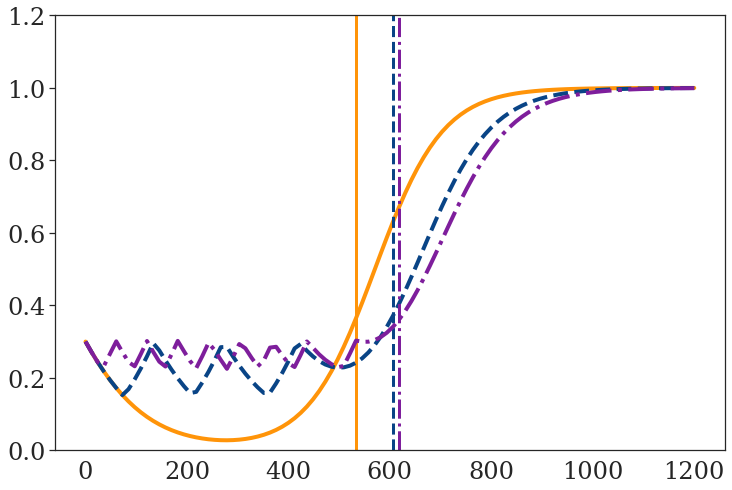

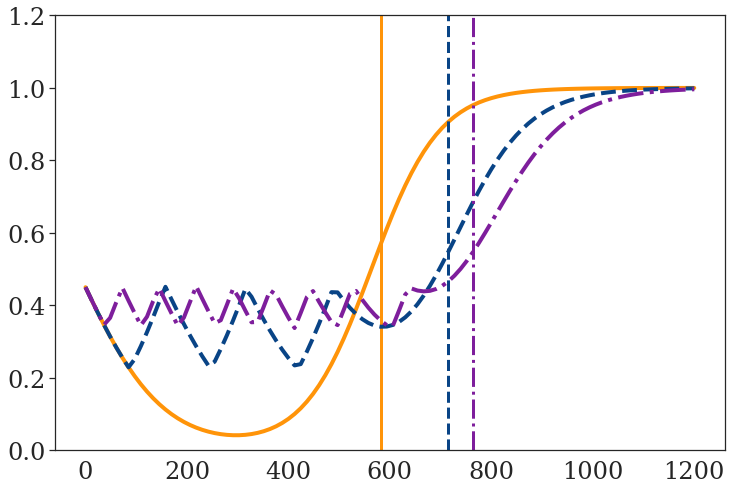

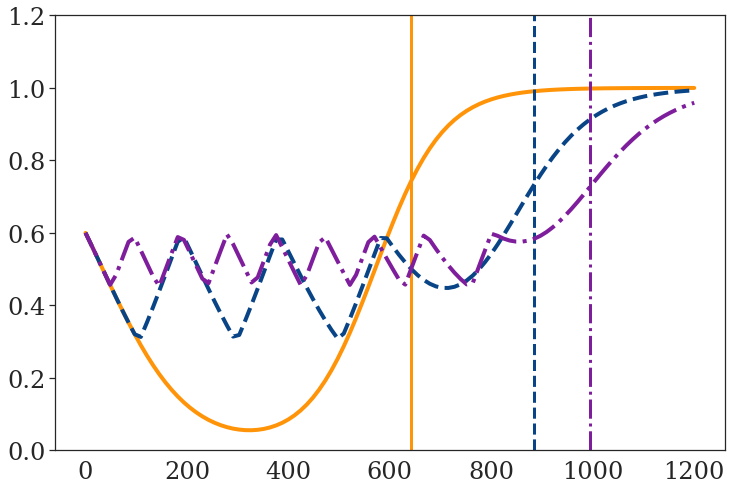

In [31]:
tEnd = 1200


cost = 0
rpuThresholdList = [1.,0.5, 0.25]
currParamDic = paramDic.copy()
currParamDic['rR'] *= (1-cost)

for i,initialSize in enumerate([x for x in [0.3,0.45,.60]]):
    for j,sFrac in enumerate([0.999]):
        PlotDifferentRPUThresholds(model=lotka_volterra,initialPopSize=initialSize,sFrac=sFrac,ylim=1.2, pesticide_dose = False,
                          rpuThresholdList=rpuThresholdList,paramDic=currParamDic,
                          savefigB=True,outName="figures/timeSeriesPlot_noTurnover_noCost_iS_%1.2f_sFrac_%1.2f.pdf"%(initialSize,sFrac))

In [34]:
# --------------------------- Ploting comparison -----------------------------------------------------


def PlotSimulation(dataDf,pesticideConcentrationVec=None,sizeVar="V",plotSizeB=False,plotPopsB=True,
                       pesticideBarPosition=0.85,plotLegendB=True,plotpesticideBarB=True,
                       yLimVec=[0,1.5], y2lim=1, ax=None, figsize=(10,8), titleStr="", **kwargs):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
    lnslist = []
    # Plot the size the we will see on the images
    if plotSizeB:

        propV = dataDf.V_max.values

        lnslist += ax.plot(dataDf.Time,
                            dataDf[sizeVar],
                            lw=kwargs.get('linewidthA', 4), color=kwargs.get('colorA', 'b'),
                            linestyle=kwargs.get('linestyleA', '-'), marker=kwargs.get('markerA', None),
                            label=kwargs.get('labelA', 'Model Prediction'))

        lnslist += ax.plot(dataDf.Time,
                            (propV) * dataDf["V_max"],
                            lw=kwargs.get('linewidth', 4), linestyle=kwargs.get('linestyleV_max', '--'),
                            color=kwargs.get('colorV_max', '#dbba16'),
                            label='V_max')                            

    # Plot the individual populations
    if plotPopsB:
        propS = dataDf.S.values / (dataDf.S.values + dataDf.R.values)
        
        lnslist += ax.plot(dataDf.Time,
                            propS * dataDf[sizeVar],
                            lw=kwargs.get('linewidth', 4), linestyle=kwargs.get('linestyleS', '--'),
                            color=kwargs.get('colorS', "#0F4C13"),
                            label='S')
        lnslist += ax.plot(dataDf.Time,
                            (1 - propS) * dataDf[sizeVar],
                            lw=kwargs.get('linewidth', 4), linestyle=kwargs.get('linestyleR', '--'),
                            color=kwargs.get('colorR', '#710303'),
                            label='R')
                    


    # Plot the pesticide concentration
    if plotpesticideBarB:
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        pesticideConcentrationVec = pesticideConcentrationVec/(1-pesticideBarPosition)+pesticideBarPosition
        ax2.fill_between(dataDf.Time,
                         pesticideBarPosition, pesticideConcentrationVec, color="gray",
                         alpha=1., label="Pesticide Concentration")
        ax2.set_ylim([0, y2lim])
        ax2.axis("off")
    # Format the plot
    plt.xlim([0, kwargs.get('xlim', 1.1*dataDf.Time.max())])
    ax.set_ylim(yLimVec)
    ax.tick_params(labelsize=24)
    plt.title(titleStr)
    if plotLegendB:
        labsList = [l.get_label() for l in lnslist]
        plt.legend(lnslist, labsList, loc=kwargs.get('legendLoc', "upper right"))
    plt.tight_layout()
    if kwargs.get('savefigB', False):
        plt.savefig(kwargs.get('outName', 'modelPrediction.png'), orientation='portrait', format='png')

def GenerateATComparisonPlot(initialTumourSize, rFrac, paramDic,
                             modelFun = lotka_volterra,
                             normaliseToStartingValue = False,
                             t_end=1500, relToPopEq=False,
                             decorateX=True, decorateY=False,
                             intervalLength=1., nTimePts=100, rpuThreshold=0.5,
                             printDifferenceInTTP=False, markInitialSize=False,
                             ylim=1.3, figsize=(8, 5),
                             colorA='#094486',  
                             ax=None,
                             outName=None):
    if relToPopEq: initialTumourSize *= (1 - paramDic['dS'] / paramDic['rS'])
    initialStateVec, _ = GenerateParameterDic(initialSize=initialTumourSize, rFrac=rFrac, cost=0, turnover=0,
                                              paramDic=paramDic)

    # Simulate
    resultsDf_max = Simulate_non_int_fixed_target(modelFun=modelFun,
                                           initialStateVec=initialStateVec,
                                           rpuThreshold=1., intervalLength=t_end,
                                           paramDic=paramDic,
                                           t_end=t_end, t_eval=np.linspace(0, t_end, nTimePts))
    ttp_ct = resultsDf_max.Time[resultsDf_max.V > 1.2 * initialTumourSize].min()

    resultsDf = Simulate_non_int_fixed_target(modelFun=modelFun,
                                           initialStateVec=initialStateVec,
                                           rpuThreshold=rpuThreshold, intervalLength=intervalLength,
                                           paramDic=paramDic,
                                           t_end=t_end, t_eval=np.linspace(0, t_end, nTimePts))
    ttp_AT = resultsDf.Time[resultsDf.V > 1.2 * initialTumourSize].min()

    # Plot the results
    extracted_col = resultsDf_max["V"]
    

    if ax is None: fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=figsize)
    if normaliseToStartingValue:
        resultsDf['V'] /= resultsDf['V'].iloc[0]
        resultsDf['S'] /= resultsDf['V'].iloc[0]
        resultsDf['R'] /= resultsDf['V'].iloc[0]
    PlotSimulation(resultsDf, sizeVar="V", pesticideConcentrationVec=resultsDf.D, xlim=t_end,
                   linewidthA=4, linewidth=4,
                   yLimVec=[0, 1.2], y2lim=1, plotLegendB=False, decoratey2=False,
                   labelA='Volume', legendLoc='upper left',
                   colorR='#710303', colorS="#0F4C13", linestyleR='-.',
                   colorA=colorA, ax=ax)
    ax.vlines(x=ttp_ct, ymin=0, ymax=ylim, colors=[(1, 148 / 255, 9 / 255)], linestyles='-', linewidth=3)
    ax.vlines(x=ttp_AT, ymin=0, ymax=ylim, colors=sns.xkcd_rgb['purple'], linestyles='--', linewidth=3) # change color rt_threshold
    if markInitialSize: ax.hlines(xmin=0, xmax=t_end, y=initialTumourSize, linestyles='--', linewidth=3)
    ax.set_ylim(0, ylim)
    ax.set_xlabel("")
    ax.set_ylabel("")
    if not decorateX:
        ax.set_xticklabels("")
    if not decorateY:
        ax.set_yticklabels("")
    if outName is not None: plt.savefig(outName)
    if printDifferenceInTTP:
        gainInTTP = ttp_AT - ttp_ct
        relGainInTTP = (ttp_AT - ttp_ct) / ttp_ct * 100
        print("TTP_CT: %1.2f; TTP_AT: %1.2f" % (ttp_ct, ttp_AT))
        print("Relative gain: %1.2f%%; Absolute Gain: %1.2fd" % (relGainInTTP, gainInTTP))

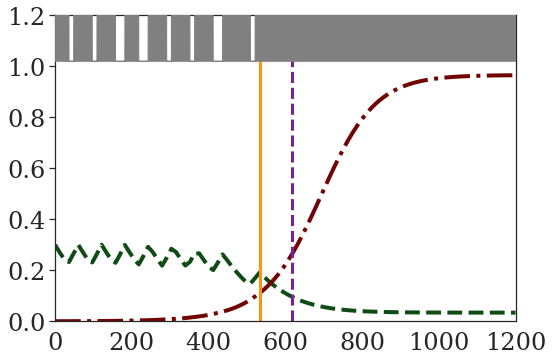

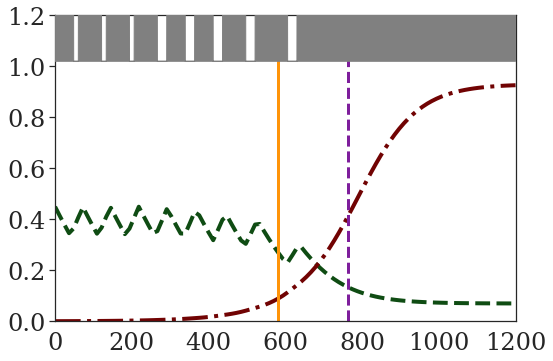

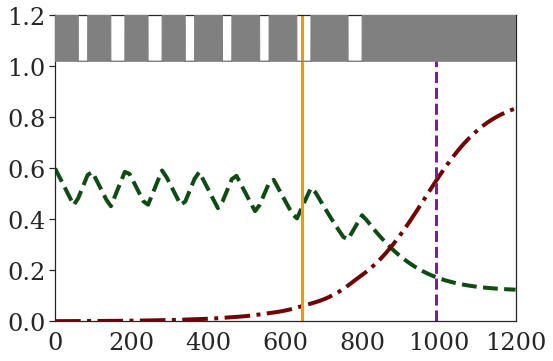

In [35]:
tEnd = 1200
deathRate = 0.2
cost = 0

currParamDic = paramDic.copy()
currParamDic['dS'] = deathRate*currParamDic['rS']
currParamDic['dR'] = deathRate*currParamDic['rR']
currParamDic['rR'] *= (1-cost)


for i,initialSize in enumerate([x for x in [0.3,0.45,.60]]):
    for j,rFrac in enumerate([0.001]):
       
        GenerateATComparisonPlot(initialTumourSize=initialSize,rFrac=rFrac, rpuThreshold = 0.25,
                                 paramDic=currParamDic,t_end=tEnd,
                                 decorateX=j==0,decorateY=True,ylim=1.2,
                                 outName="figures/timeSeriesPlot_noTurnover_noCost_iS_%1.2f_rFrac_%1.2f.pdf"%(initialSize,rFrac))